In [1]:
suppressMessages(library(readr))
suppressMessages(library(DESeq2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggplot2))
suppressMessages(library(BiocParallel))
suppressMessages(library(pheatmap))
suppressMessages(library(sva))
suppressMessages(library(reshape2))
suppressMessages(library(edgeR))
suppressMessages(library(cowplot))
suppressMessages(library(riborex))
suppressMessages(library(ggrepel))
suppressMessages(library(fdrtool))
suppressMessages(library(grid))
gene_annotation_file <- '/home/cmb-panasas2/skchoudh/genomes/hg38/annotation/hg38_gene_names_id.tsv'
gene_annotations <- read.table(gene_annotation_file,  header=T, stringsAsFactors = F, 
                               sep='\t')
rownames(gene_annotations) <- gene_annotations$gene_id
'%notin%' <- function(x,y)!('%in%'(x,y))
cbbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

colors <- list(species = c("GRCh38" = cbbPalette[5],
                            "Mmul8" =  cbbPalette[6],
                             "panTro3" =  cbbPalette[7]),
              assay = c("ribo" = cbbPalette[3],
                       "rna" =  cbbPalette[4]))

In [2]:
write_results <- function(df, results.dir, prefix){
  df<- as.data.frame(df)
  df <- df[order(df$padj),]
  df$gene_name <- gene_annotations[rownames(df),]$gene_name

  df.sig <- subset(df, padj<0.05)
  df.sig.up <- subset(df.sig, log2FoldChange>0)
  df.sig.down <- subset(df.sig, log2FoldChange<0)
  write.table(df, file = file.path(results.dir,
                                   paste(prefix, 'tsv', sep='.')), sep = '\t')

  write.table(df.sig, file = file.path(results.dir,
                                   paste(prefix, 'sig', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.up,  file = file.path(results.dir,
                                       paste(prefix, 'sig', 'up', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.down,  file = file.path(results.dir,
                                         paste(prefix, 'sig', 'down', 'tsv', sep='.')), sep = '\t')
  return (df.sig)
}

In [3]:
plotHeatMap <- function(rlogdist, filename=NULL){
  sampleDists <- dist(t(assay(rlogdist)))
  sampleDistMatrix <- as.matrix(sampleDists)
  rownames(sampleDistMatrix) <- colnames(rlogdist)#paste(rlogdist$condition, colnames(rlogdist), sep="-")
  colnames(sampleDistMatrix) <- NULL
  colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
  pheatmap(sampleDistMatrix,
           clustering_distance_rows=sampleDists,
           cellwidth=10,
           cellheight=10,
          clustering_distance_cols=sampleDists,
           col=colors,)
  if (!is.null(filename)) {
      pheatmap(sampleDistMatrix,
               cellwidth=20,
               cellheight=20,
               clustering_distance_rows=sampleDists,
               clustering_distance_cols=sampleDists,
               col=colors, filename=filename)
  }
}

In [4]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.hg38 <- subset(metadata, metadata$species == 'GRCh38')
sex <- factor(metadata.hg38$sex, levels=c("male", "female"))
assay <- factor(metadata.hg38$assay, levels=c("rna", "ribo"))

hg38.cds.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds.tsv', sep='\t', row.names=1)
hg38.cds.counts <- hg38.cds.counts[, metadata.hg38$experiment_accession]


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
Saving 7 x 7 in image


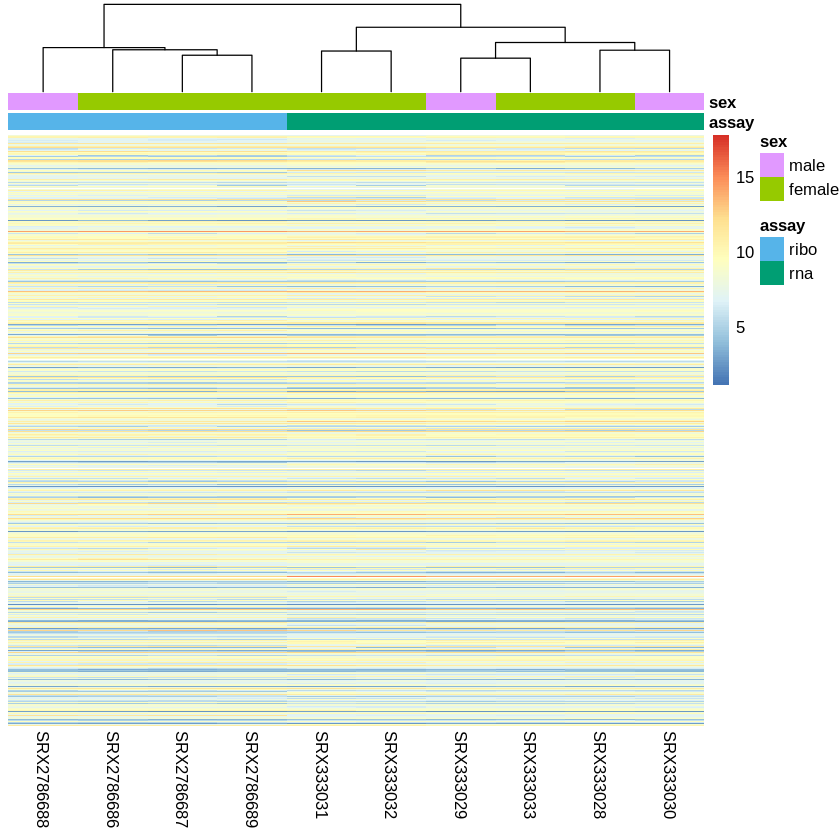

In [15]:
coldata <- data.frame(row.names=colnames(hg38.cds.counts), sex, assay)
dds <- DESeqDataSetFromMatrix(countData=hg38.cds.counts,
                              colData=coldata,
                              design=~assay)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
                 
                 
annotation.df <- as.data.frame(colData(dds)[, c("assay", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("assay", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors)
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors, file='../../re-ribo-smk/plots/GRCh38/GRCh38_cds_rna_ribo_heatmap.pdf')
                 
data <- plotPCA(rld, intgroup = c("assay", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=assay, shape=sex, label = rownames(data))) +
      scale_color_manual("assay", values=colors$assay) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12))      
ggsave('../../re-ribo-smk/plots/GRCh38/GRCh38_cds_rna_ribo_pca.pdf')    

In [6]:
results.hg38.TE <- results(dds)
write_results(results.hg38.TE,
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-datasets-translational-efficiency/", 
              "GRCh38_TE")


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
ENSG00000197837,2676.2990,9.669031,0.3109759,31.09255,3.037522e-212,3.500137e-208,HIST4H4
ENSG00000196787,5203.9176,10.646170,0.3651937,29.15212,7.853578e-187,4.524839e-183,HIST1H2AG
ENSG00000180596,3337.8640,8.447195,0.2987165,28.27830,6.390468e-176,2.454579e-172,HIST1H2BC
ENSG00000277075,7543.0500,9.739443,0.3469670,28.07023,2.262888e-173,6.518815e-170,HIST1H2AE
ENSG00000276966,7786.2828,11.132399,0.4098147,27.16447,1.708278e-162,3.936897e-159,HIST1H4E
ENSG00000196866,3755.3358,9.762192,0.3623778,26.93927,7.620170e-160,1.463454e-156,HIST1H2AD
ENSG00000276180,2800.4432,10.411882,0.3903692,26.67188,9.977685e-157,1.642470e-153,HIST1H4I
ENSG00000282988,5728.3295,9.657033,0.3744540,25.78964,1.158874e-146,1.669213e-143,RP1-34B20.21
ENSG00000278828,6705.4113,9.817934,0.3885573,25.26766,7.244367e-141,9.275205e-138,HIST1H3H
ENSG00000233822,476.0645,7.548186,0.3030296,24.90907,5.933179e-137,6.836802e-134,HIST1H2BN


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Saving 7 x 7 in image


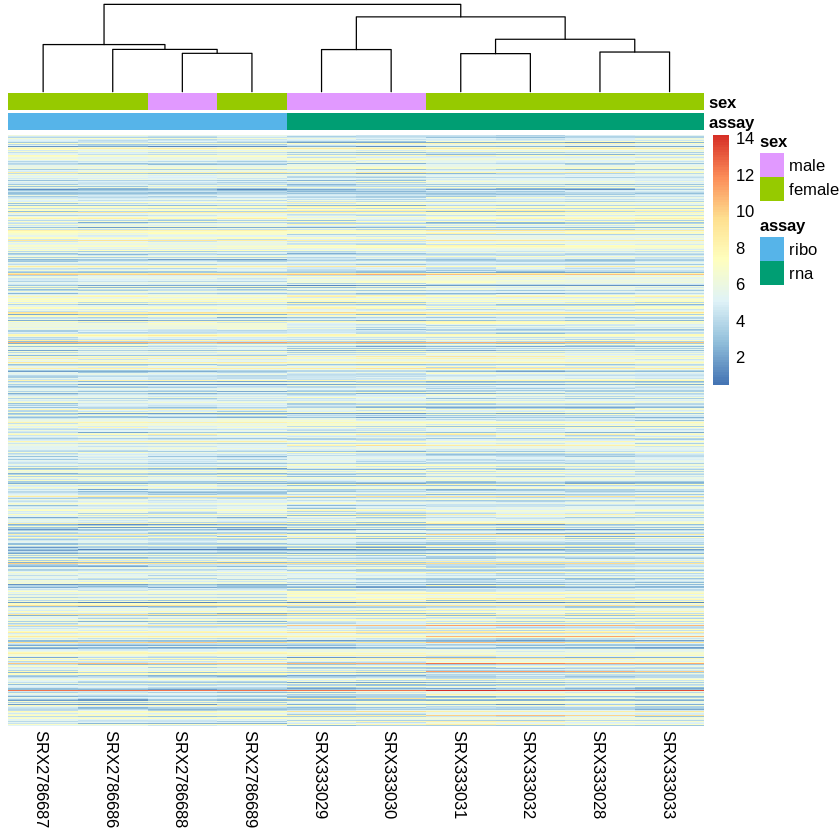

In [11]:
hg38.uORF.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF.tsv', sep='\t', row.names=1)
hg38.uORF.counts <- hg38.uORF.counts[, metadata.hg38$experiment_accession]

coldata <- data.frame(row.names=colnames(hg38.uORF.counts), sex, assay)
dds <- DESeqDataSetFromMatrix(countData=hg38.uORF.counts,
                              colData=coldata,
                              design=~assay)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
                 
                 
annotation.df <- as.data.frame(colData(dds)[, c("assay", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("assay", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors) 
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors, file='../../re-ribo-smk/plots/GRCh38/GRCh38_uORF_rna_ribo_heatmap.pdf')
                 
data <- plotPCA(rld, intgroup = c("assay", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=assay, shape=sex, label = rownames(data))) +
      scale_color_manual("assay", values=colors$assay) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12))      
ggsave('../../re-ribo-smk/plots/GRCh38/GRCh38_uORF_rna_ribo_pca.pdf')

In [8]:
results.hg38.dORF <- results(dds)
write_results(results.hg38.dORF,
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-datasets-translational-efficiency/", 
              "GRCh38_dORF")


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
ENSG00000087086,2461.49778,-6.976418,0.3378376,-20.650213,9.719036e-95,5.106382e-91,FTL
ENSG00000167996,1150.54597,-4.894859,0.2871826,-17.044411,3.845971e-65,1.010337e-61,FTH1
ENSG00000092931,921.94334,-6.676931,0.4052243,-16.477125,5.357265e-61,9.382356e-58,MFSD11
ENSG00000150967,356.58120,-6.455226,0.4387197,-14.713782,5.258446e-49,6.906969e-46,ABCB9
ENSG00000109103,165.10332,-6.567229,0.5043147,-13.022087,9.163157e-39,9.628646e-36,UNC119
ENSG00000048162,317.94330,-6.020439,0.4635275,-12.988310,1.425407e-38,1.248181e-35,NOP16
ENSG00000122406,2946.20809,-4.593148,0.3615005,-12.705785,5.491547e-37,4.121798e-34,RPL5
ENSG00000198843,390.31728,2.893662,0.2301834,12.571119,3.043830e-36,1.999035e-33,SELT
ENSG00000121716,209.98386,-5.526345,0.4532963,-12.191464,3.451635e-34,2.014988e-31,PILRB
ENSG00000174444,2337.28174,-4.261563,0.3511020,-12.137678,6.669206e-34,3.504001e-31,RPL4
